PRE-INSTALLATION OF ALL THE USED PACKAGES AND LIBRARIES

In [1]:
%pip install --upgrade pip
%pip install SPARQLWrapper pandas matplotlib numpy Pillow requests scikit-learn ipywidgets scipy


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


The following Python script queries Wikidata for information about cars, downloads their images, and extracts metadata, including image size, format, orientation, creation date, and EXIF data. The script handles potential errors during image processing and saves the metadata for the downloaded images in a JSON file. The goal is to create a comprehensive dataset of car images with associated metadata for further analysis or use.

In [2]:

import os
from SPARQLWrapper import SPARQLWrapper, JSON
from PIL import Image
import json
import urllib
import time
import re
from PIL.ExifTags import TAGS

endpoint_url = "https://query.wikidata.org/sparql"

query = """SELECT DISTINCT ?car ?carLabel ?image {
  ?car wdt:P31 wd:Q1420;
       wdt:P18 ?image.
 SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}
LIMIT 10"""

def get_results(endpoint_url, query):
    user_agent = "me/1.0 (me@email.com)"
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()

def download_image_metadata(images_folder, data, limit=10):
    # Ensure the images folder exists
    if not os.path.exists(images_folder):
        os.makedirs(images_folder)

    # List to accumulate metadata for all images
    all_metadata = []

    for i, result in enumerate(data["results"]["bindings"]):
        if i >= limit:
            break

        car_label = result.get("carLabel", {}).get("value", f"UnknownCar_{i + 1}")
        # Remove special characters from the car label for file path
        car_label_cleaned = re.sub(r'\W+', '', car_label)
        image_url = result.get("image", {}).get("value", "")

        image_name = f"{car_label_cleaned}_image_{i + 1}.jpg"
        image_path = os.path.join(images_folder, image_name)

        try:
            # Download the image from Wikidata
            urllib.request.urlretrieve(image_url, image_path)

            print(f"Downloaded: {image_name}")

            # Get metadata and accumulate in the list
            metadata = get_metadata(image_path)
            all_metadata.append(metadata)

            # Introduce a delay between requests to comply with rate limits
            time.sleep(1)

        except Exception as e:
            print(f"Error processing image {image_name}: {e}")

    # Ensure the json folder exists
    if not os.path.exists(json_folder):
        os.makedirs(json_folder)
        
    # Save all metadata to a single JSON file
    json_file_path = os.path.join(json_folder,"metadata.json")
    with open(json_file_path, "w") as json_file:
        json.dump(all_metadata, json_file, indent=4)

    print(f"All metadata saved to: {json_file_path}")


def get_exif_metadata(exif_data):
    if exif_data:
        exif_metadata = {}
        for tag, value in exif_data.items():
            tag_name = TAGS.get(tag, tag)
            # Exclude problematic values
            if isinstance(value, bytes):
                continue
            # Convert non-serializable types to string
            if isinstance(value, (str, int, float)):
                exif_metadata[tag_name] = value
            else:
                exif_metadata[tag_name] = str(value)
        return exif_metadata
    return {}

def get_metadata(image_path):
    with Image.open(image_path) as img:
        exif_data = img._getexif()  # Get EXIF data
        metadata = {
            "image_name": os.path.basename(image_path),
            "image_size": img.size,
            "image_format": img.format,
            "image_orientation": get_image_orientation(exif_data),
            "creation_date": get_creation_date(exif_data),
            "exif_metadata": get_exif_metadata(exif_data),
        }
        return metadata

def get_image_orientation(exif_data):
    if exif_data:
        orientation = exif_data.get(274)  # 274 corresponds to the 'Orientation' tag
        if orientation is not None:
            return orientation
    return "Unknown"

def get_creation_date(exif_data):
    if exif_data:
        date_time_original = exif_data.get(36867)  # 36867 corresponds to 'DateTimeOriginal' tag
        if date_time_original is not None:
            return date_time_original
    return "Unknown"

if __name__ == "__main__":
    # Specify the folder paths
    images_folder = "*images*"
    json_folder = "*json*"

    # Get results from Wikidata
    results = get_results(endpoint_url, query)

    # Download images and save metadata
    download_image_metadata(images_folder, results, limit=10)



Downloaded: Kharkovchanka_image_1.jpg
Downloaded: Ferrari250GTBoanoEllenacar_image_2.jpg
Downloaded: Fiat770_image_3.jpg
Downloaded: CampagnaTRex_image_4.jpg
Downloaded: CG1200S_image_5.jpg
Downloaded: VAZ2104_image_6.jpg
Downloaded: Fiat1500Lcar_image_7.jpg
Downloaded: Fiat500Giardiniera_image_8.jpg
Downloaded: Ferrari250P_image_9.jpg
Downloaded: GeelyKingKong_image_10.jpg
All metadata saved to: *json*/metadata.json


Now, we are going to use the following script to determine the 3 predominant colors in each image by using the KMeans algorithm. The script will also save the results in a JSON file. 

In [3]:
import os
import json
from PIL import Image
import pandas as pd
from sklearn.cluster import KMeans

def extract_colors(image_path, num_colors=3):
    image = Image.open(image_path)
    # Resize the image to a small size for faster processing
    resized_image = image.resize((50, 50))
    pixels = list(resized_image.getdata())

    # Use K-Means clustering to find the predominant colors
    kmeans = KMeans(n_clusters=num_colors)
    kmeans.fit(pixels)
    predominant_colors = kmeans.cluster_centers_.astype(int)

    return predominant_colors.tolist()

def process_images(folder_path, num_colors=3):
    data = []

    for filename in os.listdir(folder_path):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(folder_path, filename)
            colors = extract_colors(image_path, num_colors)
            data.append({'Image': filename, 'Predominant Colors': colors})
            print(f"Processed: {filename}")

    return pd.DataFrame(data)




if __name__ == "__main__":
    
    folder_path = "*images*" 
    output_json_path = "*json*/predominant_colors.json"  

    # Process images and create DataFrame
    df = process_images(folder_path)

    # Save the DataFrame to a JSON file
    df.to_json(output_json_path, orient="records", indent=4)
    
    data = json.load(open(output_json_path))
    dataframe = pd.json_normalize(data)
   
    print(dataframe)
    
    
    


Processed: Kharkovchanka_image_1.jpg
Processed: GeelyKingKong_image_10.jpg
Processed: CG1200S_image_5.jpg
Processed: Fiat770_image_3.jpg
Processed: Fiat500Giardiniera_image_8.jpg
Processed: VAZ2104_image_6.jpg
Processed: Fiat1500Lcar_image_7.jpg
Processed: CampagnaTRex_image_4.jpg
Processed: Ferrari250GTBoanoEllenacar_image_2.jpg
Processed: Ferrari250P_image_9.jpg
                                    Image  \
0               Kharkovchanka_image_1.jpg   
1              GeelyKingKong_image_10.jpg   
2                     CG1200S_image_5.jpg   
3                     Fiat770_image_3.jpg   
4          Fiat500Giardiniera_image_8.jpg   
5                     VAZ2104_image_6.jpg   
6                Fiat1500Lcar_image_7.jpg   
7                CampagnaTRex_image_4.jpg   
8  Ferrari250GTBoanoEllenacar_image_2.jpg   
9                 Ferrari250P_image_9.jpg   

                                 Predominant Colors  
0  [[64, 52, 42], [186, 187, 190], [102, 107, 125]]  
1  [[138, 134, 122], [199, 19

To have a good exploitation of the predominate colors, we will convert them into the more close color name. For this, we will use distance between colors in the RGB space. 

Also, we will analayze the color orientation and the size of each image.


In [4]:
import json

output_json_path_colors = "*json*/predominant_colors.json"
output_json_path = "*json*/metadata.json"


# Get the predominant colors, the size for each image
json_file_color = json.load(open(output_json_path_colors))
json_file = json.load(open(output_json_path))

image_colors = [image['Predominant Colors'] for image in json_file_color]


image_sizes = [image['image_size'] for image in json_file]  




## CODE FOR COLOR MAPPING


from scipy.spatial import distance


def color_distance(color1, color2):
    """
    Calculate the Euclidean distance between two RGB colors.
    """
    return distance.euclidean(color1, color2)

def closest_color(rgb, predefined_colors):
    """
    Find the closest predefined color for a given RGB color.
    """
    min_distance = float('inf')
    closest_color = None

    for category, predefined_color in predefined_colors.items():
        dist = color_distance(rgb, predefined_color)
        if dist < min_distance:
            min_distance = dist
            closest_color = category

    return closest_color

# Define predefined colors
predefined_colors = {
    'red': [255, 0, 0],
    'white': [255, 255, 255],
    'black': [0, 0, 0],
    'yellow': [255, 255, 0],
    'green': [0, 255, 0],
    'orange': [255, 165, 0],
    'blue': [0, 0, 255],
    'purple': [128, 0, 128],
    'brown': [165, 42, 42],
    'pink': [255, 192, 203],
    'gray': [128, 128, 128],
}

# Map the closest predefined color for each liked color
mapped_colors = []

for image_colors in image_colors:
    mapped_image_colors = []
    for color in image_colors:
        closest = closest_color(color, predefined_colors)
        mapped_image_colors.append(closest)
    mapped_colors.append(mapped_image_colors)



# Replace the predominant colors with the mapped colors in the json file
for i, image in enumerate(json_file):
    image['Predominant Colors'] = mapped_colors[i]

# Replace the json file with the updated data
with open(output_json_path_colors, 'w') as f:
    json.dump(json_file, f, indent=4)
    print(f"Updated JSON file: {output_json_path_colors}")
    

# orientation and size
# Determination of the size (thumbnail, small, medium, large, full) of the image
mapped_image_sizes = []
for size in image_sizes:
    width, height = size
    if width < 300 and height < 300:
        mapped_image_sizes.append('Thumbnail')
    elif width < 800 and height < 800:
        mapped_image_sizes.append('Small')
    elif width < 1920 and height < 1080:
        mapped_image_sizes.append('Medium')
    elif width < 3840 and height < 2160:
        mapped_image_sizes.append('Large')
    else:
        mapped_image_sizes.append('Full')



# Determination of the orientation based on the image size
image_orientations = []
for size in image_sizes:
    width, height = size
    if width > height:
        image_orientations.append('Landscape')
    elif width < height:
        image_orientations.append('Portrait')
    else:
        image_orientations.append('Square')

# Add the orientation to the json file
for i, image in enumerate(json_file):
    image['image_orientation'] = image_orientations[i]
    image['image_size'] = mapped_image_sizes[i]


# Replace the json file with the updated data
with open(output_json_path, 'w') as f:
    json.dump(json_file, f, indent=4)
    print(f"Updated JSON file: {output_json_path}")




Updated JSON file: *json*/predominant_colors.json
Updated JSON file: *json*/metadata.json


After that, we will ask the user to select some images and add tags. For every user, we are now ready to build a user-preference profile, based on this selection. We may collect the following information manually, but the objective of this task is to obtain them using the selected images in an automated manner.
The following information will be collected:
    - Favorite colors
    - Favorite image orientation
    - Favorite image sizes (thumbnail images, large images, medium-size images, etc.)
    - Favorite tags



In [11]:
import os
import json
from IPython.display import display, Image, clear_output
import ipywidgets as widgets
import random

# Specify the folder path containing the images
folder_path = "*images*"

# Specify the output JSON file path
output_json_path = "*json*/image_ratings.json"  # Replace with the actual path for the output JSON file

# Create an empty list to store the image ratings
image_ratings = []

# Get the list of image file names in the folder (10 random images)


image_files = random.sample(os.listdir(folder_path), 10)


# Shuffle the list of image files
random.shuffle(image_files)

def create_event_handlers(image_file):
    def like_button_clicked(b):
        image_ratings.append({'image_name': image_file, 'Preference': 'like'})
        display_next_image()

    def dislike_button_clicked(b):
        image_ratings.append({'image_name': image_file, 'Preference': 'dislike'})
        display_next_image()

    return like_button_clicked, dislike_button_clicked

def display_next_image():
    global image_index
    if image_index < len(image_files):
        image_file = image_files[image_index]
        image_widget = Image(filename=os.path.join(folder_path, image_file))
        like_button, dislike_button = create_event_handlers(image_file)
        like_button_widget = widgets.Button(description='Like')
        dislike_button_widget = widgets.Button(description='Dislike')
        like_button_widget.on_click(like_button)
        dislike_button_widget.on_click(dislike_button)
        buttons_box = widgets.HBox([like_button_widget, dislike_button_widget])
        image_widget.height = 300
        image_widget.width = 300
        clear_output(wait=True)
        display(image_widget, buttons_box)
        image_index += 1
    else:
        # All images have been displayed
        clear_output(wait=True)
        print("All images have been rated.")
        # Save the image ratings to the output JSON file
        with open(output_json_path, 'w') as json_file:
            json.dump(image_ratings, json_file, indent=4)
        print("Image ratings saved to:", output_json_path)

# Display the first image
image_index = 0
display_next_image()


All images have been rated.
Image ratings saved to: *json*/image_ratings.json


Now, from the image ratings, we will build a user-preference profile.
First, we will determine the user's favorite colors by using the predominant colors in the selected images.

In [12]:
import json

# Read the image ratings from the JSON file
with open("*json*/image_ratings.json") as json_file:
    image_ratings = json.load(json_file)

# Filter the image ratings to get the liked images
liked_images = [rating["image_name"] for rating in image_ratings if rating["Preference"] == "like"]

# Read the predominant colors from the JSON file
with open("*json*/predominant_colors.json") as json_file:
    predominant_colors = json.load(json_file)

# Filter the predominant colors based on the liked images
liked_colors = [color["Predominant Colors"] for color in predominant_colors if color["image_name"] in liked_images]


# Get the most common colors among the liked images
from collections import Counter

# Flatten the list of colors
flattened_colors = [color for image_colors in liked_colors for color in image_colors]

# Count the frequency of each color
color_counts = Counter(flattened_colors)

# Get the 3 most common colors without their frequencies
most_common_colors = [color for color, _ in color_counts.most_common(3)]


# Add the liked images and the most common colors to user-preference JSON file
user_preferences = {
    "liked_images": liked_images,
    "most_common_colors": most_common_colors
}

# Save the user preferences to a JSON file
user_preferences_json_path = "*json*/user_preferences.json" 

with open(user_preferences_json_path, "w") as json_file:
    json.dump(user_preferences, json_file, indent=4)
    print(f"User preferences saved to: {user_preferences_json_path}")




User preferences saved to: *json*/user_preferences.json


Then, we will determine the user's favorite image orientation and favorite image size by using the selected images.

In [13]:
import json

# Read the metadata.json file and load the data
metadata_file = "*json*/metadata.json"  # Replace with the actual path to your metadata.json file
with open(metadata_file) as file:
    metadata = json.load(file)

# Filter the metadata for the liked images from the user preferences
user_preferences_file = "*json*/user_preferences.json"  # Replace with the actual path to your user_preferences.json file
with open(user_preferences_file) as file:
    user_preferences = json.load(file)
    

liked_metadata = [img for img in metadata if img["image_name"] in user_preferences["liked_images"]]

orientation_preference = []
size_preference = []

for img in liked_metadata:
    orientation_preference.append(img["image_orientation"])
    size_preference.append(img["image_size"])

# Get the most common orientation and size among the liked images
from collections import Counter

most_common_orientation = Counter(orientation_preference).most_common(1)[0][0]
most_common_size = Counter(size_preference).most_common(1)[0][0]

# Add the most common orientation and size to the user preferences
user_preferences["most_common_orientation"] = most_common_orientation
user_preferences["most_common_size"] = most_common_size

# Save the updated user preferences to the JSON file
with open(user_preferences_file, "w") as file:
    json.dump(user_preferences, file, indent=4)
    print(f"Updated user preferences saved to: {user_preferences_file}")




  
    
    
    
    



    


Updated user preferences saved to: *json*/user_preferences.json


DATA VISUALIZATION
Here, we will visualize the different characteristics of all the downloaded images, such as the available number of images for every year, the available number of images for different types: image size, image orientation, camera models, etc and also the predominant colors in the images.

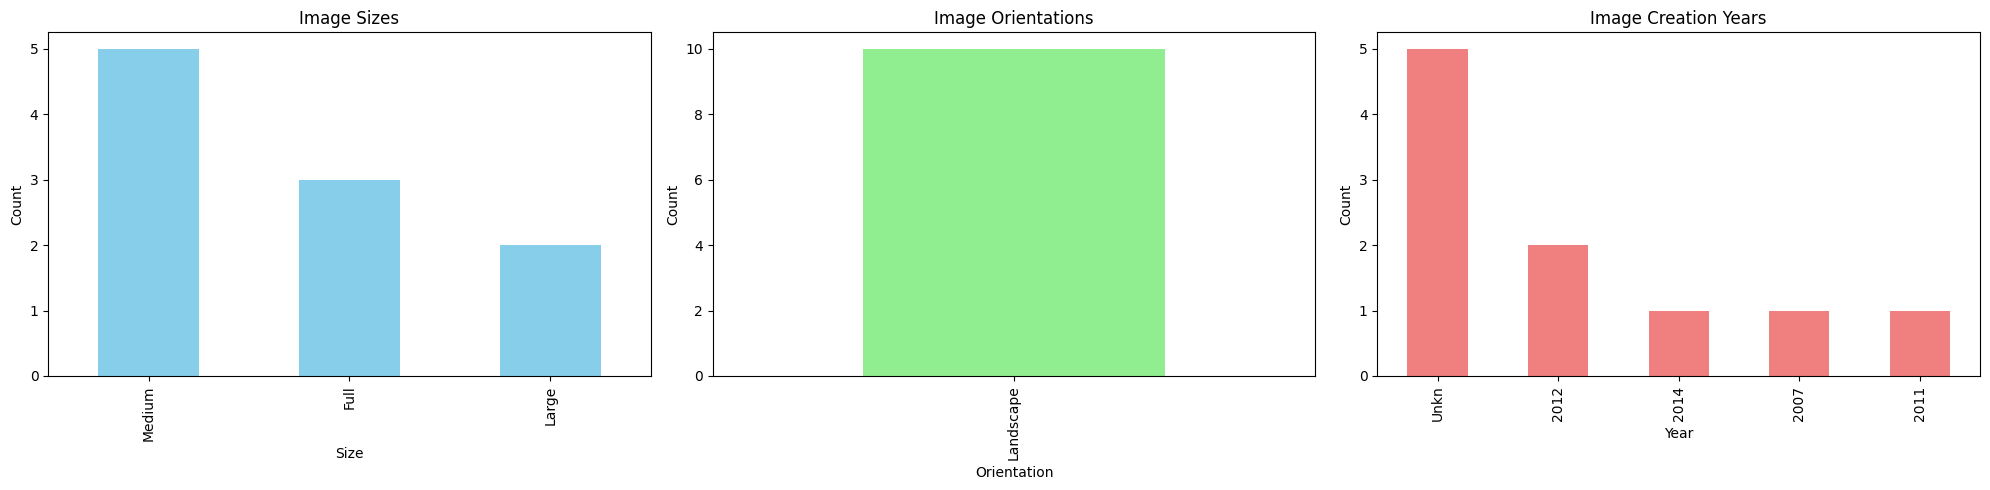

In [18]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# Read the metadata.json file and load the data
metadata_file = "*json*//metadata.json"
with open(metadata_file) as file:
    metadata = json.load(file)

# Convert the metadata to a DataFrame
metadata_df = pd.json_normalize(metadata)

# Get the differents items (size, orientation, creation date) and their counts
size_counts = metadata_df["image_size"].value_counts()
orientation_counts = metadata_df["image_orientation"].value_counts()

# extract the year from the creation date
metadata_df["creation_year"] = metadata_df["creation_date"].str[:4]
year_counts = metadata_df["creation_year"].value_counts()

# Plot the counts for each item
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
size_counts.plot(kind="bar", ax=axes[0], color="skyblue")
axes[0].set_title("Image Sizes")
axes[0].set_xlabel("Size")
axes[0].set_ylabel("Count")
orientation_counts.plot(kind="bar", ax=axes[1], color="lightgreen")
axes[1].set_title("Image Orientations")
axes[1].set_xlabel("Orientation")
axes[1].set_ylabel("Count")
year_counts.plot(kind="bar", ax=axes[2], color="lightcoral")
axes[2].set_title("Image Creation Years")
axes[2].set_xlabel("Year")
axes[2].set_ylabel("Count")
plt.tight_layout()
plt.show()
